In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy.stats import norm, skew

from sklearn.grid_search import GridSearchCV

D:\ANACONDA\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\ANACONDA\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [279]:
#常用模型
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR


In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.drop('Id', axis = 1, inplace = True)
test_df.drop('Id', axis = 1, inplace = True)

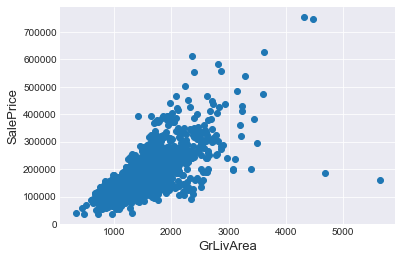

In [240]:
plt.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [4]:
#删除这个离群值
train_df = train_df.drop(train_df[(train_df['GrLivArea'] >= 4000) & (train_df['SalePrice'] <= 300000)].index)

In [5]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

In [239]:
# data_df = pd.concat((train_df, test_df)).reset_index(drop=True)
y = np.array(train_df.SalePrice.as_matrix())

# data_df.drop('SalePrice', axis = 1, inplace = True)

In [8]:
data_df.isnull().sum().sort_values(ascending = False).head()


PoolQC         2908
MiscFeature    2812
Alley          2719
Fence          2346
FireplaceQu    1420
dtype: int64

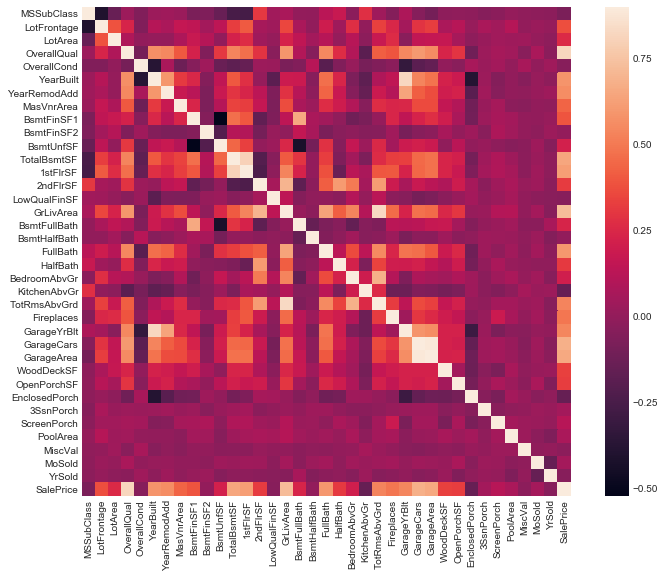

In [245]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train_df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [9]:
#填充PoolQC的缺失值
data_df.loc[data_df.PoolQC.isnull(), 'PoolQC'] = 'missing'

In [10]:
#同样的填充
data_df.loc[data_df.MiscFeature.isnull(), 'MiscFeature'] = 'missing'
data_df.loc[data_df.Alley.isnull(), 'Alley'] = 'missing'
data_df.loc[data_df.Fence.isnull(), 'Fence'] = 'missing'

In [11]:
data_df.loc[data_df.FireplaceQu.isnull(), 'FireplaceQu'] = 'missing'

In [12]:
data_df.isnull().sum().sort_values(ascending = False).head()

LotFrontage     486
GarageCond      159
GarageFinish    159
GarageQual      159
GarageYrBlt     159
dtype: int64

In [13]:
data_df.loc[data_df.LotFrontage.isnull(), 'LotFrontage'] = data_df.LotFrontage.median()

In [14]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_df[col] = data_df[col].fillna('None')
    
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    data_df[col] = data_df[col].fillna(0)

In [15]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data_df[col] = data_df[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    data_df[col] = data_df[col].fillna('None')

In [16]:
data_df.loc[data_df.MasVnrArea.isnull(), 'MasVnrArea'] = 0
data_df.loc[data_df.MasVnrType.isnull(), 'MasVnrType'] = 'missing'

In [17]:
data_df.MSZoning.value_counts()
data_df.loc[data_df.MSZoning.isnull(), 'MSZoning'] = 'RL'

In [18]:
data_df.drop('Utilities', axis = 1, inplace = True)
data_df.loc[data_df.Functional.isnull(), 'Functional'] = 'Typ'
data_df['Electrical'] = data_df['Electrical'].fillna(data_df['Electrical'].mode()[0])
data_df['KitchenQual'] = data_df['KitchenQual'].fillna(data_df['KitchenQual'].mode()[0])

data_df['Exterior1st'] = data_df['Exterior1st'].fillna(data_df['Exterior1st'].mode()[0])
data_df['Exterior2nd'] = data_df['Exterior2nd'].fillna(data_df['Exterior2nd'].mode()[0])

In [19]:
data_df['SaleType'] = data_df['SaleType'].fillna(data_df['SaleType'].mode()[0])

In [21]:
data_df.isnull().sum().sum()#没有缺失值了

0

In [22]:
#MSSubClass=The building class
data_df['MSSubClass'] = data_df['MSSubClass'].astype(str)


#Changing OverallCond into a categorical variable
data_df['OverallCond'] = data_df['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
data_df['YrSold'] = data_df['YrSold'].astype(str)
data_df['MoSold'] = data_df['MoSold'].astype(str)

In [23]:
data_df.dtypes.value_counts()

object     46
int64      21
float64    11
dtype: int64

In [25]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data_df[c].values)) 
    data_df[c] = lbl.transform(list(data_df[c].values))

In [26]:
# Adding total sqfootage feature 
data_df['TotalSF'] = data_df['TotalBsmtSF'] + data_df['1stFlrSF'] + data_df['2ndFlrSF']

In [33]:
numeric_feats = data_df.dtypes[data_df.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data_df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [38]:
skewness.loc['TotalSF']

Skew    1.009157
Name: TotalSF, dtype: float64

In [39]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    data_df[feat] = boxcox1p(data_df[feat], lam)

There are 59 skewed numerical features to Box Cox transform


In [54]:
data_df.dtypes[data_df.dtypes == 'uint8'].index

Index(['BldgType_1Fam', 'BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_Twnhs',
       'BldgType_TwnhsE', 'Condition1_Artery', 'Condition1_Feedr',
       'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN',
       ...
       'SaleCondition_Partial', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD'],
      dtype='object', length=162)

In [45]:
data_df = pd.get_dummies(data_df)
print(data_df.shape)

(2917, 221)


In [182]:
data_df.isnull().sum().sum()

0

In [49]:
data_df.dtypes.value_counts()

uint8      162
float64     59
dtype: int64

In [50]:
X = data_df[:len(train_df)]
test_np = data_df[len(train_df):]

In [51]:
print(X.shape, test_np.shape, y.shape)

(1458, 221) (1459, 221) (1458,)


In [55]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [154]:
train = X.as_matrix()
test = test_np.as_matrix()

In [174]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train)
    rmse= np.sqrt(-cross_val_score(model, train, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [167]:

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [168]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [60]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [78]:

param_dist = {
#                   "n_estimators": [200,500,720,800,1000],  
#               "subsample": [i/10 for i in range(3,10)],
#                 "colsample_bytree":[i/10 for i in range(3,10)],
#                 "max_bin":[20,30,55,70,100,200],
#                   "max_depth": [3,4,5,6,7],  
#               "num_leaves": [3,4,5,6,7],  
#     "min_child_weight":[i/2 for i in range(1,5)],
#                   "learning_rate" : [0.01, 0.05, 0.1],  
    "reg_alpha":[0.05,0.1,1],
    "reg_lambda":[0.05,0.1,1]
             }  
gsearch1 = GridSearchCV(lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=4, max_depth=3, learning_rate=0.1, n_estimators=500, 
                       max_bin=30,min_child_weight=0.5, subsample=0.9, colsample_bytree=0.4, reg_alpha=0.1, reg_lambda=0.05),
                        n_jobs=1, param_grid=param_dist, cv = 5, scoring="neg_mean_squared_error", verbose=0)  

gsearch1.fit(train,y)  
gsearch1.best_params_, gsearch1.best_score_

({'reg_alpha': 0.1, 'reg_lambda': 0.05}, -0.013797219004235322)

In [80]:
model_lgb = gsearch1.best_estimator_ 
rmsle_cv(model_lgb).mean()

0.11730995448183808

In [83]:
pred = 0
for model in (ENet, GBoost, KRR, lasso, model_xgb, model_lgb):
    model.fit(train, y)
    pred += np.expm1(model.predict(test))
pred /= 6

In [88]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  

In [243]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



In [250]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y.reshape(-1, 1))
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [251]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1084 (0.0076)


In [252]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [254]:
stacked_averaged_models.fit(train, y)
stacked_train_pred = stacked_averaged_models.predict(train)
stacked_pred = np.expm1(stacked_averaged_models.predict(test))
print(rmsle(y, stacked_train_pred))

0.0808867548093


In [255]:
model_xgb.fit(train, y)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y, xgb_train_pred))

0.0794323047813


In [257]:
model_lgb.fit(train, y)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(rmsle(y, lgb_train_pred))

0.0737845525719


In [282]:
param_test4 = {
#     'n_estimators':[8,10,12,15,20,25],
    'max_samples':[i/10.0 for i in range(1,10)],
    'max_features':[i/10.0 for i in range(2,9)]
}
gsearch1 = GridSearchCV(BaggingRegressor(Ridge(alpha=15), n_estimators=25, max_samples=0.8, max_features=0.7,\
                                          bootstrap=True, bootstrap_features=False, n_jobs=1), 
                       param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=1,iid=False, cv=5)
gsearch1.fit(train,y)

gsearch1.best_params_, gsearch1.best_score_

({'max_features': 0.8, 'max_samples': 0.9}, -0.013871031323572435)

In [283]:
model_ridge = gsearch1.best_estimator_
model_ridge.fit(train, y)
ridge_train_pred = model_ridge.predict(train)
ridge_pred = np.expm1(model_ridge.predict(test))
print(rmsle(y, ridge_train_pred))

0.105891937673


In [284]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgb_train_pred*0.10 +  ridge_train_pred *0.10))

RMSLE score on train data:
0.0804779212022


In [285]:
predict_test = (0.7*stacked_pred+ 0.1*xgb_pred + lgb_pred*0.1 + 0.1*ridge_pred)

In [272]:
predict_test =stacked_pred

In [286]:
test_df = pd.read_csv('data/test.csv')
result = pd.DataFrame({'Id':test_df['Id'].as_matrix(), 'SalePrice':predict_test})
#写成标准的数据上传格式
result.to_csv("pred_label/stack_model.csv", index=False)  #

In [287]:
result

,Id,SalePrice
0,1461,120154.548037
1,1462,160240.403680
2,1463,185785.714519
3,1464,195785.097222
4,1465,191897.574359
5,1466,171640.835102
6,1467,176593.973574
7,1468,161791.268149
8,1469,184571.640758
9,1470,121438.112619
